In [1]:
# !pip show tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 需要安装cudatoolkit、cudnn之后并且搭配tensorflow<2.11
# 限制GPU使用，让GPU的使用按需增长
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu,True)
        except RuntimeError as e:
            print(e)
else:
    print("Got no GPUs")
# tf.config.experimental.get_memory_info('GPU:0')
# tf.keras.backend.clear_session()


In [3]:
# 加载数据集
(ds_train, ds_test), ds_info = tfds.load(
    "fashion_mnist",
    download=False,
    split=["train", "test"],
    shuffle_files=False,
    as_supervised=True,
    with_info=True,
)

In [4]:
print(ds_train)

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [5]:
# 对image做标准化处理
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label


# 将图片进行映射
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits["train"].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [6]:
# 查看tuple中shape的情况：先转化为numpy的触发器，再取下一batch
print(ds_train.as_numpy_iterator().next()[0].shape)
print(ds_train)
# ds_train为tuple类型

(128, 28, 28, 1)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


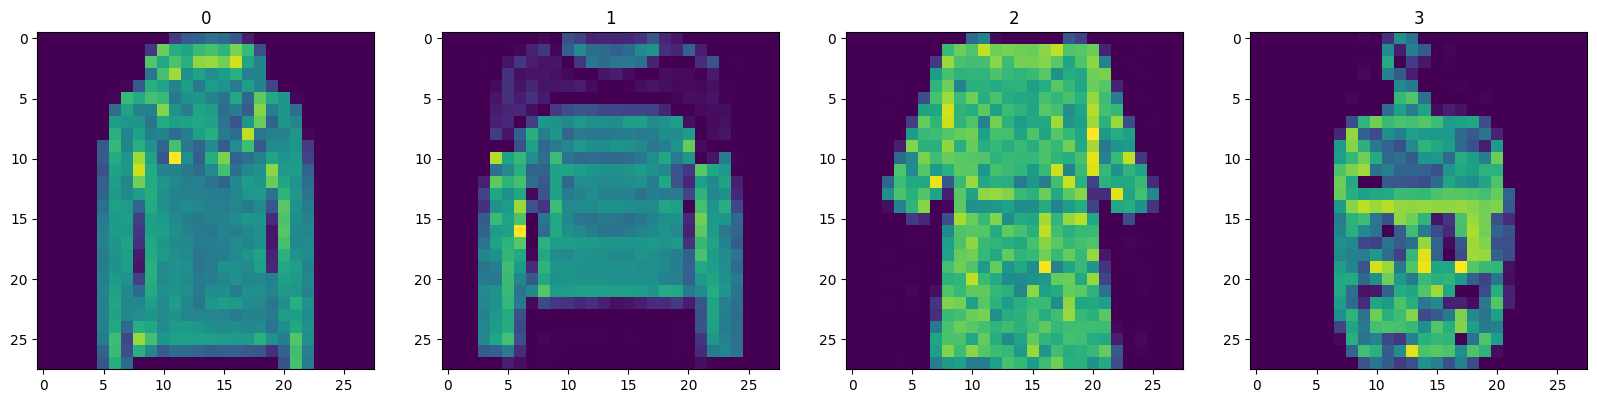

In [7]:
# 数据展示
# ncols(n):一行n列
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    images = ds_train.as_numpy_iterator().next()[0]
    ax[idx].imshow(np.squeeze(images[127]))  # 获取每个batch的第一张图片
    ax[idx].title.set_text(idx)

In [8]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    Reshape,
    UpSampling2D,
    Flatten,
)

In [9]:
# 构建Generator模型
def build_generator():
    model = Sequential()
    # 第一层，Dense表示全连接层
    model.add(Dense(7 * 7 * 128, input_dim=128))  # 7*7为图像大小，128通道的噪声
    model.add(LeakyReLU(0.2))  # 添加过滤器（激活函数）
    model.add(Reshape((7, 7, 128)))  # 图像输出

    # upsample 采样层1
    model.add(UpSampling2D())
    model.add(Conv2D(128, (5, 5), padding="same"))  # 添加卷积层
    model.add(LeakyReLU(0.2))  # 添加过滤器（激活函数）

    # upsample 采样层2
    model.add(UpSampling2D())
    model.add(Conv2D(128, (5, 5), padding="same"))
    model.add(LeakyReLU(0.2))

    # ConV 卷积层1
    model.add(Conv2D(128, (4, 4), padding="same"))
    model.add(LeakyReLU(0.2))

    # ConV 卷积层2
    model.add(Conv2D(128, (4, 4), padding="same"))
    model.add(LeakyReLU(0.2))

    # 输出层
    model.add(Conv2D(1, (4, 4), padding="same", activation="sigmoid"))

    return model

In [10]:
generator = build_generator()

In [11]:
generator.summary()
# 809088=(输入128+偏置量1)*(输出7*7*128)
# 409728=(过滤器5*5*通道128+偏置量1)*(卷积层输出128)
# 262272=(过滤器4*4*通道128+偏置量1)*(卷积层输出128)
# 2049=(过滤器4*4*通道128+偏置量1)*(卷积层输出1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 2s 2s/step


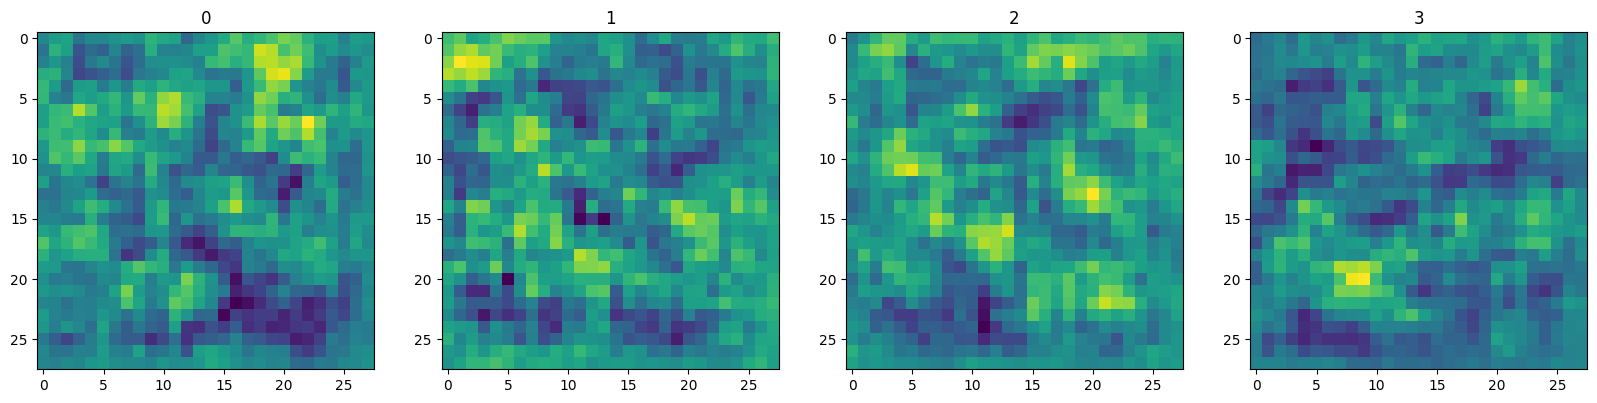

In [12]:
imgs = generator.predict(np.random.randn(4, 128))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    ax[idx].imshow(np.squeeze(imgs[idx])) 
    ax[idx].title.set_text(idx)

In [13]:
# 构建discriminator模型
def build_discriminator():
    model = Sequential()
    # First Conv
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))  # Dropout删除40%的参数

    # Second Conv
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(
        Dense(
            1,activation='sigmoid'
        )
    )
    return model

In [14]:
discriminator = build_discriminator()

In [15]:
# discriminator.summary()
# 832=(输入5*5*通道1+偏置量1)*输出32
# 51264=(输入5*5*通道32+偏置量1)*输出64
# 20928=(输入5*5*通道64+偏置量1)*输出128
# 819456=(输入5*5*通道128+偏置量1)*输出256
# Flatten平滑层36864=(输入12*12*通道256)


In [16]:
# 预测图片真伪，0为假1为真
discriminator.predict(imgs)

1/1 [==============================] - 0s 48ms/step


array([[0.496345  ],
       [0.4961928 ],
       [0.49641433],
       [0.49636063]], dtype=float32)

In [17]:
from keras.models import Model
from keras.optimizers import RMSprop
from keras.losses import BinaryCrossentropy

In [18]:
d_opt = RMSprop(learning_rate=0.00001)
g_opt = RMSprop(learning_rate=0.0001)
d_loss = BinaryCrossentropy()
g_loss = BinaryCrossentropy()
latent_dim = 128

In [19]:
# 定义Generative Adversarial Neural Network类
# *args:同arg1, arg2...
# **kwargs: 字典类型，放最后输入
class GAN(Model):
    def __init__(self, discriminator, generator, latent_dim, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, d_loss, g_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.d_loss(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        # 误导让鉴别器以为生成器生成的都是真图片
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.g_loss(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [20]:
gan = GAN(discriminator, generator, latent_dim)

In [21]:
gan.compile(d_opt,g_opt,d_loss,g_loss)

In [22]:
# 训练两个网络
gan.fit(ds_train, epochs=10)

Epoch 1/10


469/469 [==============================] - 22s 43ms/step - d_loss: 0.6915 - g_loss: 0.7071
Epoch 2/10
469/469 [==============================] - 19s 40ms/step - d_loss: 0.6903 - g_loss: 0.7467
Epoch 3/10
469/469 [==============================] - 19s 40ms/step - d_loss: 0.6909 - g_loss: 0.7490
Epoch 4/10
469/469 [==============================] - 19s 39ms/step - d_loss: 0.6915 - g_loss: 0.7466
Epoch 5/10
469/469 [==============================] - 19s 39ms/step - d_loss: 0.6915 - g_loss: 0.7468
Epoch 6/10
469/469 [==============================] - 19s 39ms/step - d_loss: 0.6917 - g_loss: 0.7457
Epoch 7/10
469/469 [==============================] - 19s 40ms/step - d_loss: 0.6917 - g_loss: 0.7463
Epoch 8/10
469/469 [==============================] - 18s 39ms/step - d_loss: 0.6919 - g_loss: 0.7454
Epoch 9/10
469/469 [==============================] - 19s 40ms/step - d_loss: 0.6921 - g_loss: 0.7453
Epoch 10/10
469/469 [==============================] - 19s 40ms/step - d_loss: 0.6921 - g_los

1/1 [==============================] - 0s 10ms/step


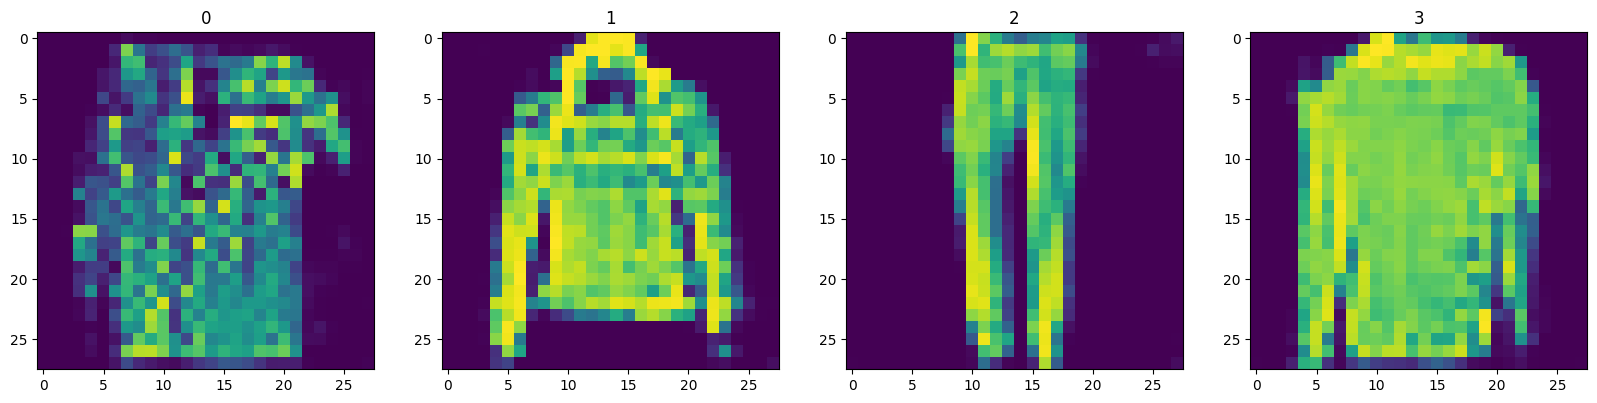

In [27]:
imgs_gen = generator.predict(np.random.randn(4, 128))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    ax[idx].imshow(np.squeeze(imgs_gen[idx]))
    ax[idx].title.set_text(idx)

In [29]:
generator.save('./model/basic_gen_model.h5')
discriminator.save('./model/basic_dis_model.h5')

In [30]:
from keras.models import load_model

1/1 [==============================] - 0s 44ms/step


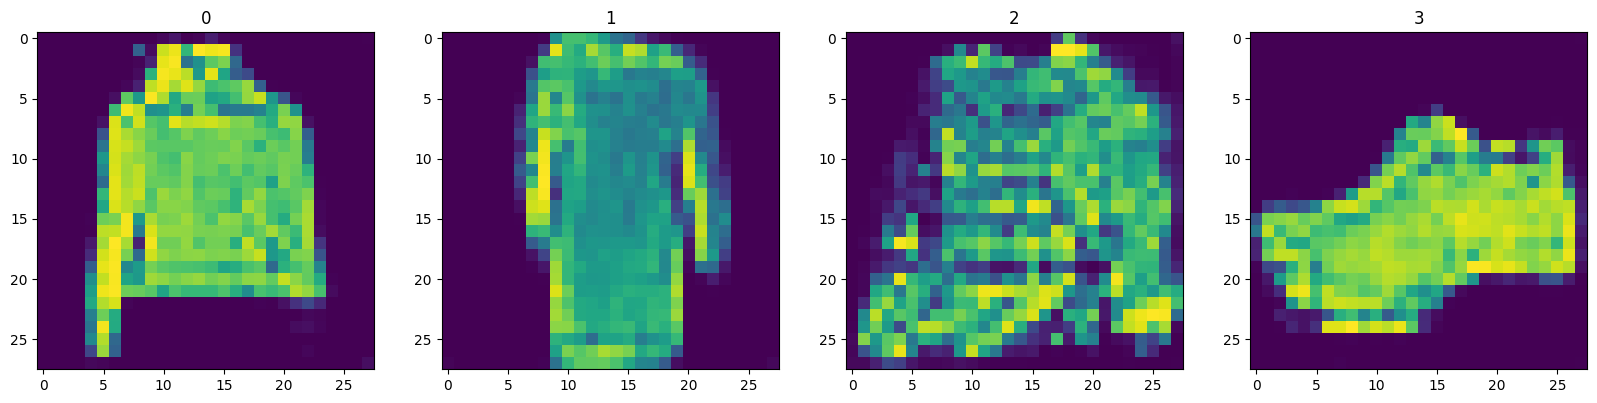

In [31]:
gen_load = load_model('./model/basic_gen_model.h5')
imgs_gen = gen_load.predict(np.random.randn(4, 128))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    ax[idx].imshow(np.squeeze(imgs_gen[idx]))
    ax[idx].title.set_text(idx)

In [ ]:
# # Construct a tf.data.Dataset
# # "split" 为 train就是没有test的数据
# # "shuffle" 就是洗乱，使其具有随机性
# ds = tfds.load("fashion_mnist", split="train", shuffle_files=True)

# # Build your input pipeline
# # "batch(n)" 批量拿n个数据
# # "prefetch" 提前放入缓存中
# ds = ds.shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
# for example in ds.take(1):
#     image, label = example["image"], example["label"]

In [ ]:
# print(np.squeeze(image))

In [ ]:
# 在上面batch中一次性拿了32个数据（图片），因此需要用序号标识
# plt.imshow(np.squeeze(image[11]))

In [ ]:
# 打印图片所属的label值，即图中物品的类型
# print(label[11])